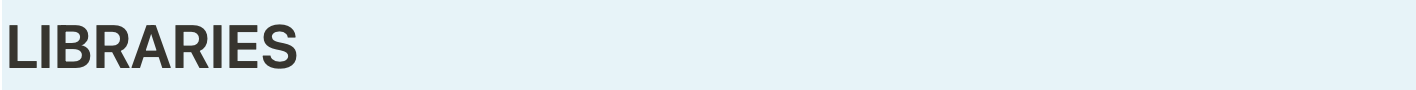

In [1]:
import os, re, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from scipy import ndimage
from skimage.transform import resize, rescale
from skimage.metrics import peak_signal_noise_ratio
from tensorflow.keras.preprocessing.image import img_to_array

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG19

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation,
    Conv2DTranspose, UpSampling2D, add, BatchNormalization,
    Concatenate, LeakyReLU
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras import layers as L
from tensorflow.keras.utils import plot_model
from keras.saving import register_keras_serializable

# Set random seed for reproducibility
np.random.seed(0)

# Check TensorFlow version
print(tf.__version__)


2.15.1


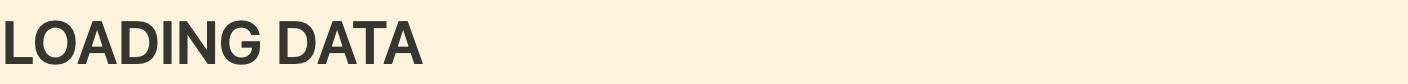

In [2]:

# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/Users/kunalnarwani/Desktop/Thesis/super-resolution/dataset/Raw Data/high_res' 
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.png':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '/Users/kunalnarwani/Desktop/Thesis/super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.png':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:810]
validation_low_image = low_img[700:810]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[810:]
test_low_image = low_img[810:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)


100%|██████████| 855/855 [00:30<00:00, 28.27it/s] 


Shape of training images: (700, 256, 256, 3)
Shape of test images: (45, 256, 256, 3)
Shape of validation images: (110, 256, 256, 3)


# ARCITECTURE OF MODEL 


In [13]:
# === Prereqs (keep once in your file) ===
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

# =========================== Global Mixed Precision ==========================
mixed_precision.set_global_policy('mixed_float16')

# ============================ Custom Resize Layers ========================== #
@register_keras_serializable(package="resize")
class ResizeByScale(L.Layer):
    """Resize spatial dims (H,W) by a float scale factor using tf.image.resize."""
    def __init__(self, scale, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = float(scale)
        self.method = method
        self.antialias = antialias

    def call(self, x):
        x_dtype = x.dtype
        x32 = tf.cast(x, tf.float32)                      # -> float32 for stable resize + grads
        h = tf.shape(x32)[1]; w = tf.shape(x32)[2]
        new_h = tf.cast(tf.round(tf.cast(h, tf.float32) * self.scale), tf.int32)
        new_w = tf.cast(tf.round(tf.cast(w, tf.float32) * self.scale), tf.int32)
        y32 = tf.image.resize(x32, size=[new_h, new_w], method=self.method, antialias=self.antialias)
        return tf.cast(y32, x_dtype)                      # back to policy dtype (likely float16)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"scale": float(self.scale), "method": self.method, "antialias": self.antialias})
        return cfg


@register_keras_serializable(package="resize")
class ResizeToMatch(L.Layer):
    """Resize x to match the spatial size (H,W) of ref."""
    def __init__(self, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.method = method
        self.antialias = antialias

    def call(self, inputs):
        x, ref = inputs
        x_dtype = x.dtype
        x32  = tf.cast(x, tf.float32)                     # ensure float32 compute
        # we only need ref's size; cast avoids mixed dtypes in internal ops
        ref32 = tf.cast(ref, tf.float32)
        target = tf.shape(ref32)[1:3]
        y32 = tf.image.resize(x32, size=target, method=self.method, antialias=self.antialias)
        return tf.cast(y32, x_dtype)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"method": self.method, "antialias": self.antialias})
        return cfg
# ============================== Core Blocks ================================= #

def conv_block(inputs, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(inputs)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    return x

def _normalize_downscales(downscales):
    """Ensure downscales is a list of 4 floats (one per encoder level)."""
    if isinstance(downscales, (float, int)):
        return [float(downscales)] * 4
    if isinstance(downscales, (list, tuple)):
        if len(downscales) != 4:
            raise ValueError(f"`downscales` must have length 4; got {len(downscales)}")
        return [float(x) for x in downscales]
    raise TypeError("`downscales` must be a float or a list/tuple of 4 floats.")

def encoder_block(inputs, num_filters, down_layer):
    x = conv_block(inputs, num_filters)
    p = down_layer(x)  # per-level downscale
    return x, p

def decoder_block(inputs, skip_features, num_filters, up_to_layer):
    x = up_to_layer([inputs, skip_features])
    x = L.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    x = L.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# ============================== Model Builder =============================== #

def build_super_resolution_unet(input_shape=(256, 256, 3), downscales=0.5, name=None):
    """
    Build U-Net with either a single downscale (applied at all 4 encoder levels)
    or a list of 4 different downscales (one per level), e.g. [0.25, 0.5, 0.75, 0.5].
    """
    ds = _normalize_downscales(downscales)

    inputs = Input(shape=input_shape)

    down_layers = [
        ResizeByScale(ds[i], method="bilinear", antialias=True,
                    name=f"enc_down_L{i+1}_{str(ds[i]).replace('.','p')}",
                    dtype="float32")
        for i in range(4)
    ]
    up_to = ResizeToMatch(method="bilinear", antialias=True, name="dec_up", dtype="float32")
    final_2x = ResizeByScale(1.0, method="bilinear", antialias=True, name="final_2x")

    # Encoder
    s1, p1 = encoder_block(inputs,  64, down_layer=down_layers[0])
    s2, p2 = encoder_block(p1,    128, down_layer=down_layers[1])
    s3, p3 = encoder_block(p2,    256, down_layer=down_layers[2])
    s4, p4 = encoder_block(p3,    512, down_layer=down_layers[3])

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512, up_to_layer=up_to)
    d2 = decoder_block(d1, s3, 256, up_to_layer=up_to)
    d3 = decoder_block(d2, s2, 128, up_to_layer=up_to)
    d4 = decoder_block(d3, s1,  64, up_to_layer=up_to)

    # Final SR head (2x)
    u1 = final_2x(d4)
    u1 = L.Conv2D(64, 3, padding="same", activation="relu")(u1)
    u1 = conv_block(u1, 64)

    outputs = L.Activation("sigmoid")(L.Conv2D(3, 1, padding="same")(u1))

    if name is None:
        tag = "-".join([str(x).replace('.', 'p') for x in ds])
        name = f"UNet_SR_ds_{tag}"  # safe name (no brackets)
    return Model(inputs, outputs, name=name)


In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top=False, weights="imagenet", input_shape=(256, 256, 3))
vgg.trainable = False
feat_extractor = tf.keras.Model(
    inputs=vgg.input,
    outputs=vgg.get_layer("block4_conv4").output,
)

alpha = tf.constant(1.0,  dtype=tf.float32)
beta  = tf.constant(0.1,  dtype=tf.float32)
gamma = tf.constant(0.01, dtype=tf.float32)

def mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    val = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.cast(val, tf.float32)

def ssim_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    val = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return tf.cast(val, tf.float32)

def perceptual_loss(y_true, y_pred):
    y_true = tf.cast(tf.clip_by_value(y_true, 0.0, 1.0), tf.float32)
    y_pred = tf.cast(tf.clip_by_value(y_pred, 0.0, 1.0), tf.float32)
    feat_true = feat_extractor(preprocess_input(y_true * 255.0))
    feat_pred = feat_extractor(preprocess_input(y_pred * 255.0))
    val = tf.reduce_mean(tf.square(feat_true - feat_pred))
    return tf.cast(val, tf.float32)

def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    total = (
        alpha * mse_loss(y_true, y_pred)
        + beta  * ssim_loss(y_true, y_pred)
        + gamma * perceptual_loss(y_true, y_pred)
    )
    return tf.cast(total, tf.float32)

def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.clip_by_value(y_pred, 0.0, 1.0), tf.float32)
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

In [9]:
# ============================== Optimizer / compile ========================= #
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ===== Compile =====
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[psnr_metric],
)

print("python exec:", sys.executable)
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

python exec: /Users/kunalnarwani/Desktop/Thesis/super-resolution/.venv/bin/python
TF version: 2.15.1
GPUs: []


In [ ]:
# =========================== Data pipelines ============================ #
AUTOTUNE = tf.data.AUTOTUNE

def make_tfds(lr_np, hr_np, batch_size=8, shuffle=True, repeat=False):
    assert len(lr_np) == len(hr_np), "LR/HR length mismatch"
    ds = tf.data.Dataset.from_tensor_slices((lr_np, hr_np))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(8_192, len(lr_np)), reshuffle_each_iteration=True)
    if repeat:
        ds = ds.repeat()
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

BATCH_SIZE = 8
train_ds = make_tfds(train_low_image, train_high_image, batch_size=BATCH_SIZE, shuffle=True, repeat=True)
valid_ds = make_tfds(validation_low_image, validation_high_image, batch_size=BATCH_SIZE, shuffle=False, repeat=False)
test_ds  = make_tfds(test_low_image,  test_high_image,  batch_size=BATCH_SIZE, shuffle=False, repeat=False)

steps_per_epoch    = max(1, len(train_low_image) // BATCH_SIZE)
validation_steps   = max(1, len(validation_low_image) // BATCH_SIZE)

# ======================== Optimizer & compile ========================== #
# Keep optimizer in float32 when using mixed precision
class AdamFloat32(tf.keras.optimizers.Adam):
    @tf.function(jit_compile=False)
    def _resource_apply_dense(self, grad, var, apply_state=None):
        return super()._resource_apply_dense(tf.cast(grad, tf.float32), var, apply_state)

def compile_model(model, lr=2e-4):
    opt = AdamFloat32(learning_rate=lr)
    model.compile(optimizer=opt,
                  loss=combined_loss,         # from your code
                  metrics=[psnr_metric])      # from your code
    return model

# ========================== Callbacks ================================= #
def make_callbacks(tag):
    ckpt_path = f"models/best_by_psnr_ds_{tag}.keras"
    os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
    early_stop = EarlyStopping(monitor='val_psnr_metric', mode='max',
                               patience=10, restore_best_weights=True, verbose=1)
    model_ckpt = ModelCheckpoint(filepath=ckpt_path, monitor='val_psnr_metric',
                                 mode='max', save_best_only=True, verbose=1)
    return [early_stop, model_ckpt], ckpt_path

# ======================= Train one configuration ====================== #
def train_one_combo(downscales, epochs=100, base_lr=2e-4, tag=None, verbose=2):
    ds_list = [float(x) for x in (downscales if isinstance(downscales, (list, tuple)) else [downscales]*4)]
    if tag is None:
        tag = "-".join([str(x).replace('.', 'p') for x in ds_list])

    model = build_super_resolution_unet(input_shape=(SIZE, SIZE, 3), downscales=ds_list, name=f"UNet_SR_ds_{tag}")
    compile_model(model, lr=base_lr)
    cbs, ckpt_path = make_callbacks(tag)

    print(f"\n=== Training combo {tag} (downscales={ds_list}) ===")
    history = model.fit(
        train_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_ds,
        validation_steps=validation_steps,
        callbacks=cbs,
        verbose=verbose
    )

    # Evaluate best weights on validation (loaded by EarlyStopping restore) and on test
    val_psnr = max(history.history.get('val_psnr_metric', [-float("inf")]))
    print(f"[{tag}] Best val PSNR: {val_psnr:.3f} dB")

    # Load the *saved* best checkpoint explicitly (in case restore_best_weights didn't coincide with checkpoint)
    try:
        best_model = tf.keras.models.load_model(
            ckpt_path,
            custom_objects={
                "ResizeByScale": ResizeByScale,
                "ResizeToMatch": ResizeToMatch,
                "combined_loss": combined_loss,
                "psnr_metric": psnr_metric
            },
            compile=False,
            safe_mode=False
        )
        compile_model(best_model, lr=base_lr)  # compile for evaluation metrics
    except Exception as e:
        print(f"Warning: failed to load checkpoint {ckpt_path}: {e}")
        best_model = model  # fallback

    # Evaluate on test set
    test_metrics = best_model.evaluate(test_ds, verbose=0, return_dict=True)
    print(f"[{tag}] Test PSNR: {test_metrics.get('psnr_metric', float('nan')):.3f} dB")

    # Optionally compute SSIM over test set (full-image average)
    ssim_vals = []
    for lr_batch, hr_batch in test_ds:
        pred = best_model.predict(lr_batch, verbose=0)
        pred = tf.clip_by_value(pred, 0.0, 1.0)
        ssim = tf.image.ssim(tf.cast(hr_batch, tf.float32), tf.cast(pred, tf.float32), max_val=1.0)
        ssim_vals.append(ssim)
    test_ssim = float(tf.reduce_mean(tf.concat(ssim_vals, axis=0)))
    print(f"[{tag}] Test SSIM: {test_ssim:.4f}")

    return {
        "tag": tag,
        "downscales": ds_list,
        "val_best_psnr": float(val_psnr),
        "test_psnr": float(test_metrics.get('psnr_metric', float('nan'))),
        "test_ssim": test_ssim,
        "ckpt_path": ckpt_path
    }

# ========================= Grid search  ===================== #
from itertools import product

def grid_search_scales(level_choices=(0.25, 0.5, 0.75), limit=None, epochs=60, base_lr=2e-4, verbose=2):
    combos = list(product(level_choices, repeat=4))
    if limit is not None:
        combos = combos[:int(limit)]
    results = []
    best = {"val_best_psnr": -1.0}
    for ds in combos:
        tag = "-".join([str(x).replace('.', 'p') for x in ds])
        res = train_one_combo(list(ds), epochs=epochs, base_lr=base_lr, tag=tag, verbose=verbose)
        results.append(res)
        if res["val_best_psnr"] > best["val_best_psnr"]:
            best = res
    print("\n=== Grid search done ===")
    print(f"Best by val PSNR: {best['val_best_psnr']:.3f} dB @ {best['downscales']} (ckpt: {best['ckpt_path']})")
    return results, best

# ============================ Run training ============================ #


results, best = grid_search_scales(level_choices=(0.25, 0.5, 0.75), limit=None, epochs=60, base_lr=2e-4, verbose=2)


=== Training combo 0p25-0p25-0p25-0p25 (downscales=[0.25, 0.25, 0.25, 0.25]) ===
Epoch 1/60

Epoch 1: val_psnr_metric improved from -inf to 11.65326, saving model to models/best_by_psnr_ds_0p25-0p25-0p25-0p25.keras
87/87 - 628s - loss: nan - psnr_metric: 20.5562 - val_loss: nan - val_psnr_metric: 11.6533 - 628s/epoch - 7s/step
Epoch 2/60

Epoch 2: val_psnr_metric improved from 11.65326 to 12.70810, saving model to models/best_by_psnr_ds_0p25-0p25-0p25-0p25.keras
87/87 - 591s - loss: nan - psnr_metric: 22.6161 - val_loss: nan - val_psnr_metric: 12.7081 - 591s/epoch - 7s/step
Epoch 3/60

Epoch 3: val_psnr_metric improved from 12.70810 to 14.06318, saving model to models/best_by_psnr_ds_0p25-0p25-0p25-0p25.keras
87/87 - 573s - loss: nan - psnr_metric: 24.2725 - val_loss: nan - val_psnr_metric: 14.0632 - 573s/epoch - 7s/step
Epoch 4/60


In [17]:
EVAL_BATCH = 8  # adjust for GPU/CPU memory
eval_ds = (
    tf.data.Dataset.from_tensor_slices((validation_low_image, validation_high_image))
      .batch(EVAL_BATCH)
      .prefetch(tf.data.AUTOTUNE)
)

all_psnr, all_ssim, all_msssim = [], [], []
n_images = 0

for lr_b, hr_b in eval_ds:
    pred_b = model(lr_b, training=False)

    if pred_b.shape[1:3] != hr_b.shape[1:3]:  # still guards future changes
        pred_b = tf.image.resize(pred_b, size=hr_b.shape[1:3], method="bicubic")

    hr_tf   = tf.cast(hr_b, tf.float32)
    pred_tf = tf.cast(tf.clip_by_value(pred_b, 0.0, 1.0), tf.float32)

    all_psnr.append(tf.image.psnr(hr_tf, pred_tf, max_val=1.0).numpy())
    all_ssim.append(tf.image.ssim(hr_tf, pred_tf, max_val=1.0).numpy())
    all_msssim.append(tf.image.ssim_multiscale(hr_tf, pred_tf, max_val=1.0).numpy())

    n_images += int(hr_b.shape[0])

def mean_std(x):
    x = np.concatenate(x, axis=0).astype(np.float64)
    return float(np.mean(x)), float(np.std(x))

m_psnr, s_psnr   = mean_std(all_psnr)
m_ssim, s_ssim   = mean_std(all_ssim)
m_msssim, s_msssim = mean_std(all_msssim)

print(f"Validation images evaluated: {n_images}")
print(f" PSNR    : {m_psnr:.4f} ± {s_psnr:.4f} dB")
print(f" SSIM    : {m_ssim:.4f} ± {s_ssim:.4f}")
print(f" MS-SSIM : {m_msssim:.4f} ± {s_msssim:.4f}")


KeyboardInterrupt: 